In [1]:
%matplotlib widget
import cameratransform as ct
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image

# Définition des dossiers contenant les données nécessaires à l'exécution du notebook (À ÉDITER)

In [ ]:
carto_dir = Path("cartos/BDALTIV2_2-0_25M_ASC_LAMB93-IGN69_D007_2022-12-16/BDALTIV2")
camdata_dir = Path("pyronear_cam_data")

# Création d'un modèle de caméra orientée et localisée avec `cameratransform`

Création d'un geodataframe des dalles dans la carto contenant une caméra (problème si les dalles recherchées sont à cheval sur deux cartos, cas relativement improbable d'une caméra couvrant la bordure entre deux départements) :

In [2]:
donnees_dir = Path("1_DONNEES_LIVRAISON_2023-01-00224/BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D007")
dalles_dir = Path("3_SUPPLEMENTS_LIVRAISON_2023-01-00224/BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D007/")
dalles_shape_file = Path("dalles.shp")

gdf_dalles = gpd.read_file(carto_dir / dalles_dir / dalles_shape_file)

Création d'un geodataframe des caméras utilisées à l'aide du fichier de référence 'API_DATA - devices.csv' :

In [3]:
cam_file = camdata_dir / "API_DATA - devices.csv"
df_cams = pd.read_csv(cam_file)
gdf_cams = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_cams.lon, df_cams.lat, crs="WGS84"), data=df_cams)
# gdf_cams = gdf_cams.to_crs(gdf_dalles.crs)

Sélection d'une caméra et récupération de ses informations

In [4]:
cam_name = "brison_4"
cam_info = gdf_cams[gdf_cams.login == cam_name].squeeze()
cam_info

id                                                8
login                                      brison_4
password                                        NaN
azimuth                                         311
pitch                                             0
lat                                       44.545155
lon                                        4.216534
elevation                                       780
specs                                    systemV0.2
last_ping                   2023-05-29T15:32:57.215
angle_of_view                                    87
software_hash                      0123456789ABCDEF
owner_id                                         11
scope                                        device
group_id                                          4
site_id                                           3
api_id                                            8
geometry         POINT (4.2165341377 44.5451545715)
Name: 7, dtype: object

Sélection d'une image test

In [5]:
test_img_path = camdata_dir / cam_name / "pyronear_brison_4_2023_07_04T06_07_57.jpg"
test_img = Image.open(test_img_path)
test_img_res = test_img.size

Génération d'un modèle de caméra à partir de ses [données techniques](https://reolink.com/fr/product/rlc-810a/#specifications) et de localisation/orientation

In [6]:
cam_device = ct.Camera(
    ct.RectilinearProjection(
        image=test_img_res,
        view_x_deg = 87,
        view_y_deg=44,
    ),
    ct.SpatialOrientationYawPitchRoll(elevation_m=cam_info.elevation,
                                      pitch_deg=cam_info.pitch,
                                      roll_deg=0,
                                      yaw_deg=cam_info.azimuth)
)

# gps pts are lat lon
cam_device.setGPSpos(cam_info.lat, cam_info.lon, cam_info.elevation)

Test de la fonctionnalité d'évaluation de l'horizon

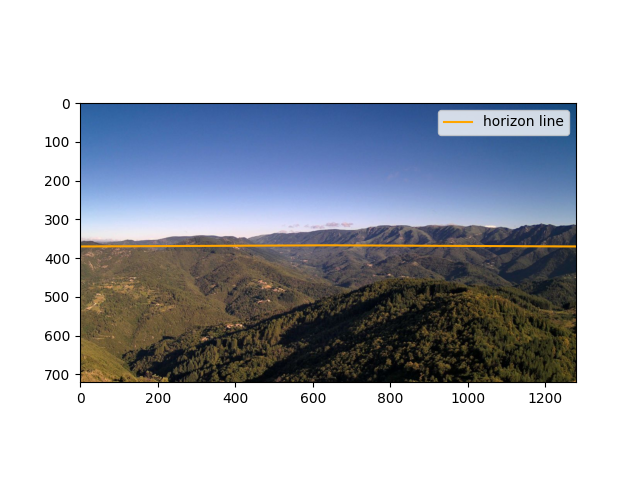

In [7]:
horizon = cam_device.getImageHorizon()

plt.plot(horizon[:, 0], horizon[:, 1], color="orange", label="horizon line")
plt.legend()
plt.imshow(np.asarray(test_img))
plt.show()

Visualisation de la projection d'un mesh de coordonnées pixels dans le repère caméra vers le repère monde en coordonnées GPS

In [8]:
img_px_mesh = np.meshgrid(np.arange(0, test_img_res[0], 600), np.arange(0, test_img_res[1], 100))
img_px_points = np.dstack(img_px_mesh).reshape(-1, 2)

In [9]:
gps_coords_points = cam_device.gpsFromImage(img_px_points)
valid_coords_mask = ~np.isnan(gps_coords_points).any(axis=1)
gps_coords_points = gps_coords_points[valid_coords_mask]  # remove NaN values from trying to project sky pixels

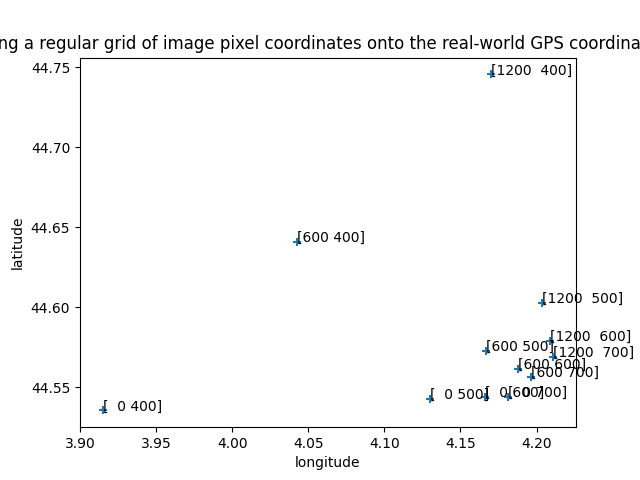

In [10]:
fig, ax = plt.subplots()

ax.scatter(gps_coords_points[:, 1], gps_coords_points[:, 0], marker="+")
for i, px_point_row in enumerate(img_px_points[valid_coords_mask]):
    ax.annotate(np.array2string(px_point_row), gps_coords_points[i, [1, 0]]) 
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title("Projecting a regular grid of image pixel coordinates onto the real-world GPS coordinates frame")
plt.show()

Récupération des données de la dalle contenant notre caméra test (on ne considère que la dalle contenant effectivement la localisation de la caméra. Peut être insuffisant si le champ couvert par la caméra s'étend sur plusieurs dalles)

# Projection des points d'une dalle IGN sur l'image test à l'aide du modèle de caméra

Sélection de la dalle contenant la caméra :

In [11]:
gdf_dalles_wgs84 = gdf_dalles.to_crs("WGS84")
dalle_cam = gdf_dalles[gdf_dalles_wgs84.geometry.contains(cam_info.geometry)].squeeze()
dalle_cam

NOM_DALLE           BDALTIV2_25M_FXX_0775_6400_MNT_LAMB93_IGN69
SRC                                                      LAMB93
SRV                                                       IGN69
DATE_DEBUT                                           2007-07-13
DATE_FIN                                             2019-03-30
PARTENAIRE                                                   NC
LITTO3D                                                     Non
PAS                                                          25
CAPTEUR                                                   ALS70
Z_MIN                                                     143.3
Z_MAX                                                    1548.6
NB_CORREL                                                     0
NB_LIDAR_T                                              1000000
NB_LIDAR_B                                                    0
NB_SMF                                                        0
NB_RADAR                                

Récupération du header associé au tableau d'altimétrie de la dalle. Ce premier contient les données de la grille de position des relevés altimétriques et la valeur associée aux données manquantes.

In [12]:
nom_dalle = dalle_cam.NOM_DALLE
dalle_file = carto_dir / donnees_dir / Path(f"{nom_dalle}.asc")

n_lines = 0
header_lines = []

with open(dalle_file, "r") as f:
    while n_lines < 6:
        header_lines.append(f.readline().split())
        n_lines += 1

header = pd.DataFrame(header_lines).set_index(0).squeeze().astype(float)
header

0
ncols              1000.0
nrows              1000.0
xllcorner        774987.5
yllcorner       6375012.5
cellsize             25.0
NODATA_value     -99999.0
Name: 1, dtype: float64

Génération du mesh de position xy correspondant au tableau d'altimétrie

In [13]:
sample_step = 10
x_mesh = (header.xllcorner + np.arange(0, header.ncols) * header.cellsize)[::sample_step]
y_mesh = np.flip(header.yllcorner + np.arange(0, header.nrows) * header.cellsize)[::sample_step]  # flip nécessaire pour avoir y croissants ascendants
xx_mesh, yy_mesh = np.meshgrid(x_mesh, y_mesh)

Récupération du tableau d'altimétrie de la dalle :

In [14]:
alts = pd.read_csv(dalle_file, sep=" ", skiprows=6, header=None).drop(0, axis=1).replace(header.NODATA_value, np.nan).values[::sample_step, ::sample_step]
print(f"NaN values found: {np.isnan(alts).any()}")

NaN values found: False


Création d'un geodataframe contenant les points de la dalle afin de facilement les projeter vers le repère de coordonnées GPS

In [15]:
sample_points_dalle = np.dstack((xx_mesh, yy_mesh, alts)).reshape(-1, 3)

gdf_spd = gpd.GeoDataFrame(geometry=gpd.points_from_xy(sample_points_dalle[:, 0], sample_points_dalle[:, 1], sample_points_dalle[:, 2]), crs=gdf_dalles.crs)
gdf_spd = gdf_spd.to_crs("WGS84")

gdf_spd[["lon", "lat", "alt"]] = pd.DataFrame(gdf_spd.geometry.map(lambda x: x.coords[0]).tolist())

Génération d'une carte de relief 3D du MNT de la dalle

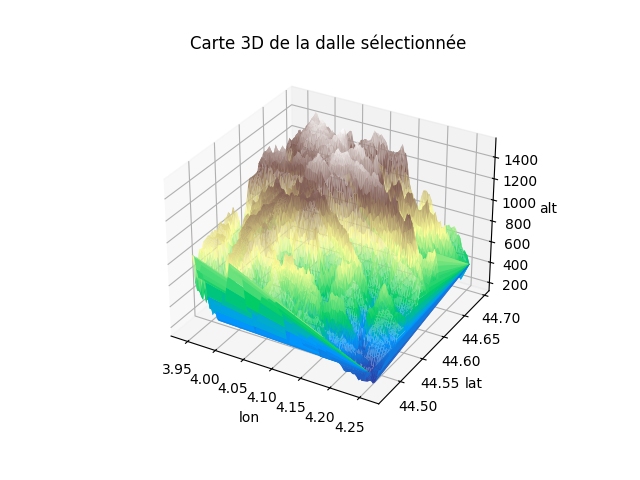

In [16]:
fig_3d_map = plt.figure()
ax_3d_map = fig_3d_map.add_subplot(111, projection='3d')
ax_3d_map.set_xlabel("lon")
ax_3d_map.set_ylabel("lat")
ax_3d_map.set_zlabel("alt")
ax_3d_map.set_title("Carte 3D de la dalle sélectionnée")

ax_3d_map.plot_trisurf(gdf_spd.lon, gdf_spd.lat, gdf_spd.alt, cmap="terrain")
plt.show()

Projection d'un échantillon non filtré de points de la dalle sur l'image test

In [17]:
proj_points_GPS = cam_device.imageFromGPS(gdf_spd[["lat", "lon", "alt"]].values)
nonan_points_idx = ~np.isnan(proj_points_GPS).any(axis=1)
proj_points_GPS = proj_points_GPS[nonan_points_idx].astype(int)

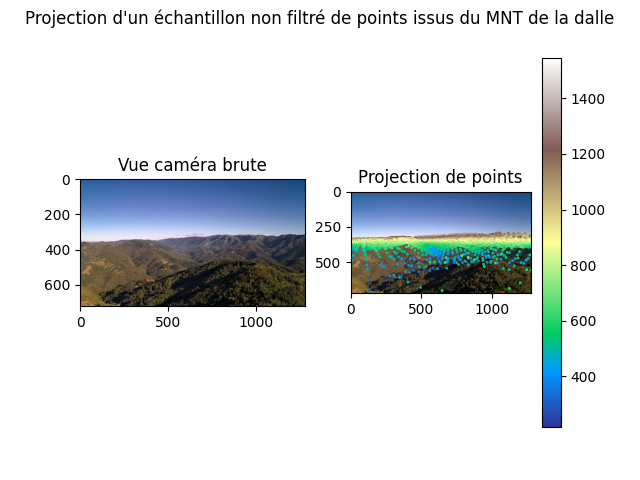

In [18]:
fig_proj = plt.figure()

ax_raw = fig_proj.add_subplot(121)
ax_raw.imshow(np.asarray(test_img))
ax_raw.set_title("Vue caméra brute")

ax_proj = fig_proj.add_subplot(122)
scatter_plot = ax_proj.scatter(proj_points_GPS[:, 0], proj_points_GPS[:, 1], c=gdf_spd.alt.values[nonan_points_idx], s=1, cmap="terrain")
ax_proj.imshow(np.asarray(test_img))
ax_proj.set_title("Projection de points")

fig_proj.suptitle("Projection d'un échantillon non filtré de points issus du MNT de la dalle")
plt.colorbar(scatter_plot)
plt.show()